atma初心者講座二回目を参考に作成
EDAを行いsub01の改善版を作成

In [10]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib_venn import venn2

In [11]:
DATA = '~/art_compe/data/'
OUT_PUT = 'out_put/2/'
os.makedirs(OUT_PUT, exist_ok=True)

In [12]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from time import time

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20

    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [13]:
import inspect

def param_to_name(params: dict, key_sep='_', key_value_sep='=') -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = '__cachefile__'
    def wrapper(*args, **kwrgs):
        force = kwrgs.pop('force', False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)

        arg_name = param_to_name(call_args)
        name = attr_name + arg_name

        use_cache = hasattr(function, name) and not force

        if use_cache:
            cache_object = getattr(function, name)
        else:
            print('run')
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)

        return cache_object

    return wrapper

In [14]:
@cachable
def read_csv(name):
    if '.csv' not in name:
        name = name + '.csv'
        
    return pd.read_csv(os.path.join(DATA, name))

In [15]:
!pip install ptitprince

In [16]:
from ptitprince import RainCloud

In [17]:
train_df = read_csv('train')
test_df = read_csv('test')

train_df['log_likes'] = np.log10(train_df['likes'] + 1)

run
run


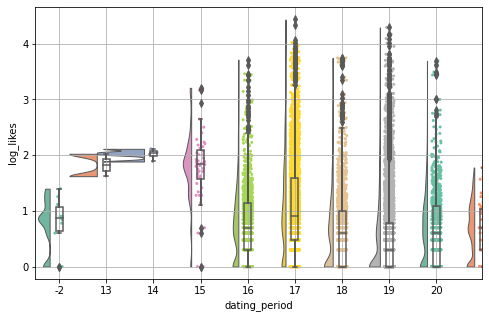

In [18]:
fig, ax = plt.subplots(figsize=(8,5))
RainCloud(data=train_df, y='log_likes',x='dating_period' , ax=ax, width_viol=2.)
ax.grid()

In [19]:
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late'
    ]
    
    return input_df[use_columns].copy()

In [20]:
def create_string_length_feature(input_df):
    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title'
        # and more
    ]
    
    out_df = pd.DataFrame()
    for column in str_columns:
        out_df[column] = input_df[column].str.len()
        
    return out_df.add_prefix('Stringlength_')

In [21]:
def create_count_encoding_feature(input_df):
    use_columns = [
        'acquisition_method',
        'title',
        'principal_maker'
    ]
    
    out_df = pd.DataFrame()
    for column in use_columns:
        vc = input_df[column].value_counts()
        out_df[column] = input_df[column].map(vc)
        
    return out_df.add_prefix('CE_')

In [22]:
def create_one_hot_encoding(input_df):
    use_columns = [
        'acquisition_method',
        'principal_maker'
    ]
    
    out_df = pd.DataFrame()
    
    for column in use_columns:
        #vc = input_df[column].value_counts()
        vc = train_df[column].value_counts()
        vc = vc[vc>20]
        
        cat = pd.Categorical(input_df[column], categories=vc.index)
        out_i = pd.get_dummies(cat)
            
        out_i.columns = out_i.columns.tolist()
        out_i = out_i.add_prefix(f'{column}=')
        out_df = pd.concat([out_df, out_i], axis=1)
    return out_df

In [23]:
from tqdm import tqdm
def to_feature(input_df):
    
    processors = [
        create_numeric_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        create_one_hot_encoding
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)
            
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [24]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)
assert len(test_feat_df) == len(test_df)

100%|██████████| 4/4 [00:00<00:00, 66.71it/s]

createcreate_numeric_feature  0.003[s]
createcreate_string_length_feature  0.026[s]
createcreate_count_encoding_feature  0.016[s]
createcreate_one_hot_encoding  0.014[s]
createcreate_numeric_feature  0.001[s]
createcreate_string_length_feature  0.026[s]
createcreate_count_encoding_feature  0.015[s]
createcreate_one_hot_encoding  0.011[s]


In [33]:
train_feat_df_like = pd.concat([train_feat_df, train_df['log_likes']], axis=1)
train_feat_df_like.T

,0,1,2,3,4,5,6,7,8,9,...,12016,12017,12018,12019,12020,12021,12022,12023,12024,12025
dating_period,17.000000,19.000000,19.000000,19.000000,19.00000,19.0,17.00000,18.0,19.0,19.0,...,17.00000,16.00000,19.0,18.000000,20.000000,19.00000,18.0,18.0,17.000000,15.000000
dating_year_early,1660.000000,1900.000000,1860.000000,1850.000000,1825.00000,1867.0,1630.00000,1718.0,1877.0,1893.0,...,1650.00000,1584.00000,1801.0,1763.000000,1935.000000,1900.00000,1701.0,1778.0,1689.000000,1500.000000
dating_year_late,1685.000000,1930.000000,1880.000000,1879.000000,1874.00000,1867.0,1632.00000,1718.0,1897.0,1893.0,...,NaN,1584.00000,1856.0,1763.000000,1936.000000,1920.00000,1714.0,1778.0,1690.000000,1535.000000
Stringlength_title,21.000000,15.000000,21.000000,16.000000,27.00000,31.0,53.00000,19.0,89.0,43.0,...,28.00000,47.00000,34.0,28.000000,14.000000,37.00000,60.0,54.0,29.000000,30.000000
Stringlength_long_title,48.000000,64.000000,52.000000,53.000000,51.00000,49.0,83.00000,41.0,134.0,91.0,...,59.00000,73.00000,64.0,56.000000,44.000000,65.00000,89.0,85.0,72.000000,75.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
principal_maker=Jan Maurits Quinkhard,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,...,0.00000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000
principal_maker=Augusta Curiel,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,...,0.00000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000
principal_maker=Jean Baptiste August Kessler,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,...,0.00000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000
principal_maker=Gerard Edelinck,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,...,0.00000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000


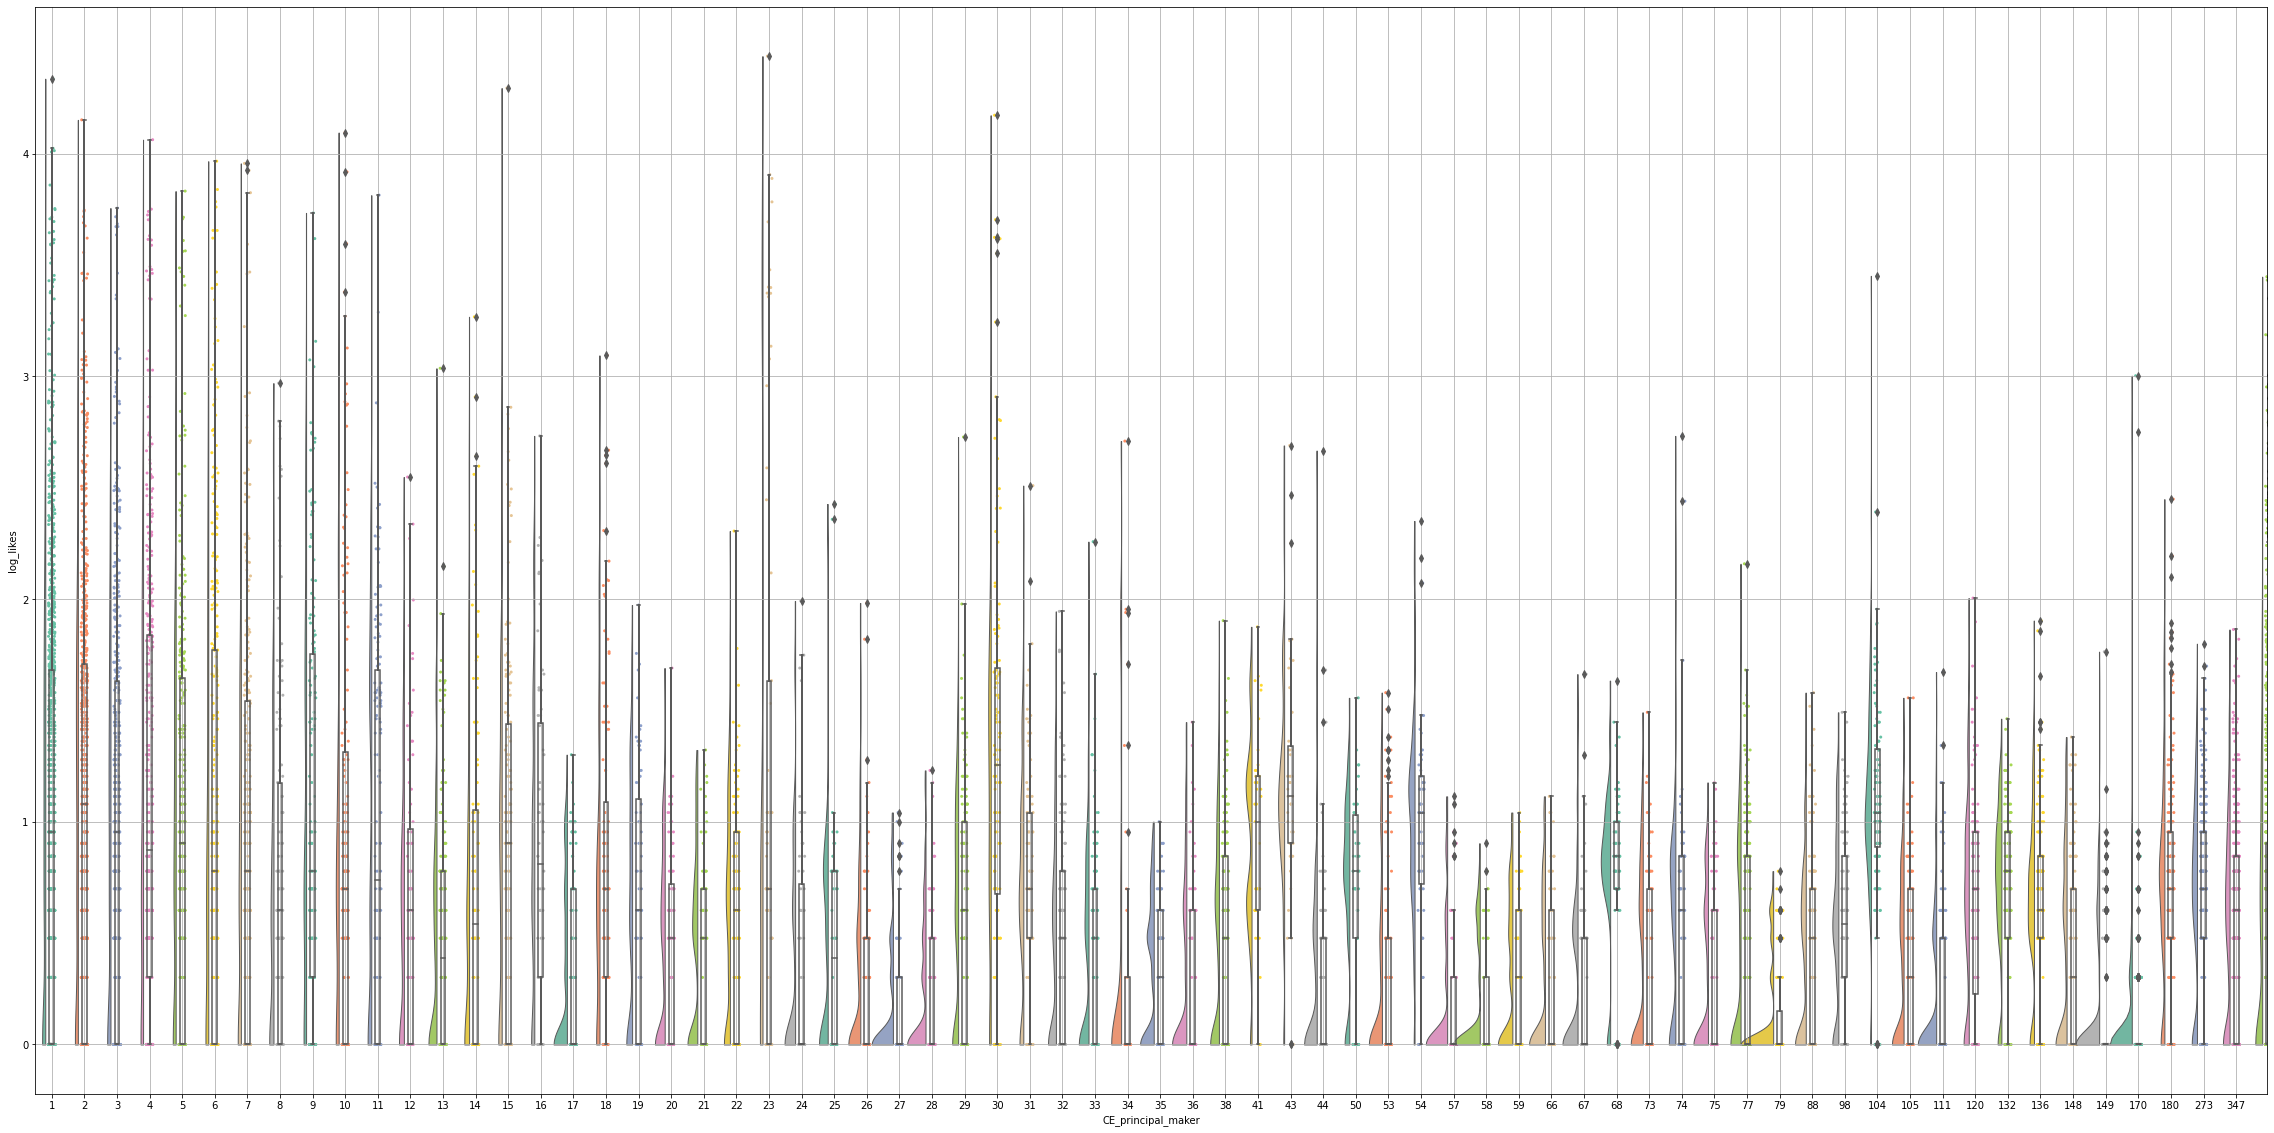

In [38]:
fig, ax = plt.subplots(figsize=(40,20))
RainCloud(data=train_feat_df_like, y='log_likes', x='CE_principal_maker', ax=ax, width_viol=2.)
ax.grid()

In [43]:
train_df.groupby('principal_maker')['likes'].agg(['std', 'mean']).dropna()

,std,mean
principal_maker,,
A. Böeseken,2.683282,1.800000
A. Mansuy,17.677670,19.500000
A. Nissen,1.732051,1.000000
A. Taupin,0.707107,0.500000
A. van de Velde,0.577350,0.666667
...,...,...
jonkheer Barthold Willem Floris van Riemsdijk,2.664583,3.500000
jonkheer Jacob Eduard van Heemskerck van Beest,56.568542,42.000000
unknown,172.996890,50.066667


In [45]:
name = 'Rembrandt van Rijn'
idx = train_df['principal_maker'] == name
train_df[idx].sort_values('likes')[['principal_maker', 'title', 'likes', 'dating_sorting_date']]

,principal_maker,title,likes,dating_sorting_date
1976,Rembrandt van Rijn,Bevrijding van Petrus uit de gevangenis,0,1635.0
1764,Rembrandt van Rijn,Jozef verklaart de dromen van de bakker en de ...,4,1616.0
2815,Rembrandt van Rijn,Heilige familie,4,1616.0
2911,Rembrandt van Rijn,Christus predikt,6,1616.0
5465,Rembrandt van Rijn,Buste van een man met tulband en baard,8,1616.0
1660,Rembrandt van Rijn,"Portrait of a man, perhaps Rembrandt's father,...",42,1730.0
1982,Rembrandt van Rijn,Laughing Young Man,130,1629.0
827,Rembrandt van Rijn,Portret van Rembrandt Harmensz. van Rijn,278,1640.0
966,Rembrandt van Rijn,Salome ontvangt het hoofd van Johannes de Doper,387,1640.0
3314,Rembrandt van Rijn,Portrait of Ephraim Bueno,906,1645.0
